# Benchmark half-life with RNA-seq

This notebook compare the half-life between FLAIR-seq and RNA-seq.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
min_ht = 0.5
max_ht = 32
print("Min half-life:", min_ht)
print("Max half-life:", max_ht)

Min half-life: 0.5
Max half-life: 32


In [2]:
d = pd.read_csv("../../4_RNAseq_ActD/reports/halflife_of_k562_genes.tsv", sep="\t")
d = d[(d["GeneType"] == "protein_coding") & (d["Canonical"])]
d = d[~d["GeneID"].duplicated()]
d.index = d["GeneID"]
d = d[(d["FPKM.0h-1"] >= 1) & (d["FPKM.0h-2"] >= 1) & (d["R2.Score"] > 0.8)]
d["T.adjusted"] = [max(min_ht, min(t, max_ht)) for t in d["T"]]
print("Number of genes in ActD: %d" % len(d))
actd = d

Number of genes in ActD: 7721


In [3]:
def comparison_with_actd_halflife(ref, ref_name, query, query_name, outfile):
    s1 = ref["T.adjusted"]
    s1.name = "Reference"
    s2 = query["T.adjusted"]
    s2.name = "Query"
    dat = pd.concat([s1, s2], axis=1, sort=False, join="inner")
    print("Number of genes in reference: %d" % len(ref))
    print("Number of genes in query: %d" % len(query))
    print("Number of common genes: %d" % len(dat))

    dat = dat[(dat.min(axis=1) > 0.5) & (dat.max(axis=1) < 32)]
    print("Number of common genes after filtering: %s" % len(dat))

    xs = np.log2(dat["Reference"])
    ys = np.log2(dat["Query"])
    print("Spearman:", spearmanr(xs, ys))
    r_s, p_s = spearmanr(xs, ys)
    assert p_s < 1e-16

    plt.figure(figsize=(3, 3))
    sns.kdeplot(x=xs, y=ys, fill=True, cmap='Blues', cbar=False, alpha=1, zorder=2)
    # plt.scatter(xs, ys, marker="o", s=10, color="blue", alpha=0.1, zorder=1)
    vmin, vmax = 0, 5
    plt.plot([vmin, vmax], [vmin, vmax], lw=1, ls="--", color="grey")
    plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.9, "$\it{r}$ = %.2f" % r_s)
    # plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.8, "p$_s$ < 10$^{-16}$")
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    plt.xlabel("Half-life (%s, h)" % ref_name)
    plt.ylabel("Half-life (%s, h)" % query_name)
    vs = np.arange(vmin, vmax + 1)
    ticks = [str(2**int(v)) for v in vs]
    plt.xticks(vs, ticks)
    plt.yticks(vs, ticks)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(outfile)

## 1. RNA-seq vs. NASC-seq

--------------------------------------------------------------------------------
Name: GSE128273
Path: ../../2_NASCseq/reports/halflife_GSE128273_K562_50uM_3h.tsv
Number of genes in reference: 7721
Number of genes in query: 9442
Number of common genes: 6448
Number of common genes after filtering: 6086
Spearman: SignificanceResult(statistic=0.7065925015589872, pvalue=0.0)
--------------------------------------------------------------------------------
Name: NASC-seq
Path: ../../2_NASCseq/reports/halflife_NASCseq_K562_50uM_3h.tsv
Number of genes in reference: 7721
Number of genes in query: 8145
Number of common genes: 6121
Number of common genes after filtering: 5828
Spearman: SignificanceResult(statistic=0.7311675965533972, pvalue=0.0)


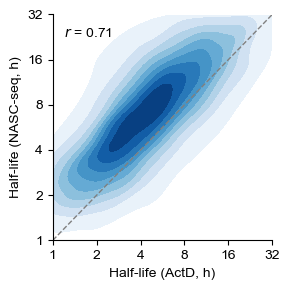

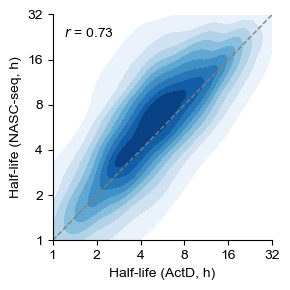

In [5]:
paths = [
    ["GSE128273", "../../2_NASCseq/reports/halflife_GSE128273_K562_50uM_3h.tsv"],
    ["NASC-seq", "../../2_NASCseq/reports/halflife_NASCseq_K562_50uM_3h.tsv"]
]

for name, path in paths:
    print("-" * 80)
    print("Name:", name)
    print("Path:", path)
    dat = pd.read_csv(path, sep="\t", index_col=0)
    dat = dat[dat["GeneType"] == "protein_coding"]
    dat = dat[dat["Canonical"]]
    dat = dat[~dat["GeneID"].duplicated()]
    dat.index = dat["GeneID"]
    dat = dat[(dat["FPKM"] >= 1) & (dat["Count"] >= 100)]
    dat["T"] = dat["T"].fillna(0)
    dat["T.adjusted"] = [max(min_ht, min(t, max_ht)) for t in dat["T"]]
    comparison_with_actd_halflife(actd, "ActD", dat, "NASC-seq", "figures/halflife_correlation_actd_vs_nascseq.%s.pdf" % name)

## 2. RNA-seq vs. FLAIR-seq

--------------------------------------------------------------------------------
Name: 1TC
Path: ../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.1TC.tsv
Number of genes in reference: 7721
Number of genes in query: 6216
Number of common genes: 4590
Number of common genes after filtering: 4387
Spearman: SignificanceResult(statistic=0.692755034502086, pvalue=0.0)
--------------------------------------------------------------------------------
Name: 2TC
Path: ../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.2TC.tsv
Number of genes in reference: 7721
Number of genes in query: 6216
Number of common genes: 4590
Number of common genes after filtering: 4171
Spearman: SignificanceResult(statistic=0.6902344843502353, pvalue=0.0)


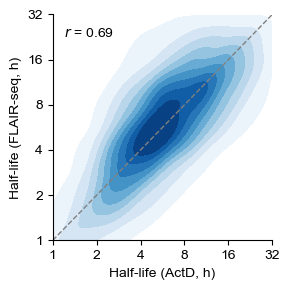

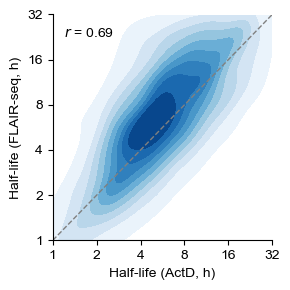

In [7]:
paths = [
    ["1TC", "../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.1TC.tsv"],
    ["2TC", "../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.2TC.tsv"]
]

for name, path in paths:
    print("-" * 80)
    print("Name:", name)
    print("Path:", path)    
    dat = pd.read_csv(path, sep="\t", index_col=0)
    dat = dat[dat["GeneType"] == "protein_coding"]
    dat = dat[(dat["Total"] >= 10)]
    dat["T.adjusted"] = [max(min_ht, min(t, max_ht)) for t in dat["T"]]
    comparison_with_actd_halflife(actd, "ActD", dat, "FLAIR-seq", "figures/halflife_correlation_actd_vs_flairseq.%s.pdf" % name)